In [1]:
#### importing original data ####
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns 
import re 
%matplotlib inline
import glob
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
# load example neighbor data 
df = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/processed_data/dfs_3_years_labeled_with_neighbors.csv', index_col = 0)
list(df.columns);

/tmp/ipykernel_293605/2530953133.py:2: DtypeWarning: Columns (164,167,172,173,177,178,187,191,196,197,198,199,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/processed_data/dfs_3_years_labeled_with_neighbors.csv', index_col = 0)


In [3]:
# create new variables: total number of neighbors defined as the total number of neighbors of each immune cell subset based on the sum of IFN+ and IFN- or the total number of cancer cell neighbors MHC+ and MHC-
# first tumor then stroma at 30 and 200 um
df['CD3+CD8-IFNy+ total Neighbors_30um'] = df['CD3+CD8-IFNy+ Tumor Neighbors_30um'] +df['CD3+CD8-IFNy+ Stroma Neighbors_30um']

df['Total CD3+CD8+ Tumor Neighbors_30um'] = df['CD3+CD8+IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8+IFNy- Tumor Neighbors_30um']
df['Total CD3+CD8- Tumor Neighbors_30um'] = df['CD3+CD8-IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8-IFNy- Tumor Neighbors_30um']
df['Total CD56+CD3- Tumor Neighbors_30um'] = df['CD56+CD3-IFNy+ Tumor Neighbors_30um'] + df['CD56+CD3-IFNy- Tumor Neighbors_30um']
df['Total PanCyto Tumor Neighbors_30um'] = df['PanCyto+MHCI+ Tumor Neighbors_30um'] + df['PanCyto+MHCI- Tumor Neighbors_30um']

df['Total CD3+CD8+ Stroma Neighbors_30um'] = df['CD3+CD8+IFNy+ Stroma Neighbors_30um'] + df['CD3+CD8+IFNy- Stroma Neighbors_30um']
df['Total CD3+CD8- Stroma Neighbors_30um'] = df['CD3+CD8-IFNy+ Stroma Neighbors_30um'] + df['CD3+CD8-IFNy- Stroma Neighbors_30um']
df['Total CD56+CD3- Stroma Neighbors_30um'] = df['CD56+CD3-IFNy+ Stroma Neighbors_30um'] + df['CD56+CD3-IFNy- Stroma Neighbors_30um']
df['Total PanCyto Stroma Neighbors_30um'] = df['PanCyto+MHCI+ Stroma Neighbors_30um'] + df['PanCyto+MHCI- Stroma Neighbors_30um']

df['Total CD3+CD8+ Tumor Neighbors_200um'] = df['CD3+CD8+IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8+IFNy- Tumor Neighbors_30um']
df['Total CD3+CD8- Tumor Neighbors_200um'] = df['CD3+CD8-IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8-IFNy- Tumor Neighbors_30um']
df['Total CD56+CD3- Tumor Neighbors_200um'] = df['CD56+CD3-IFNy+ Tumor Neighbors_30um'] + df['CD56+CD3-IFNy- Tumor Neighbors_30um']
df['Total PanCyto Tumor Neighbors_200um'] = df['PanCyto+MHCI+ Tumor Neighbors_200um'] + df['PanCyto+MHCI- Tumor Neighbors_200um']

df['Total CD3+CD8+ Stroma Neighbors_200um'] = df['CD3+CD8+IFNy+ Stroma Neighbors_200um'] + df['CD3+CD8+IFNy- Stroma Neighbors_200um']
df['Total CD3+CD8- Stroma Neighbors_200um'] = df['CD3+CD8-IFNy+ Stroma Neighbors_200um'] + df['CD3+CD8-IFNy- Stroma Neighbors_200um']
df['Total CD56+CD3- Stroma Neighbors_200um'] = df['CD56+CD3-IFNy+ Stroma Neighbors_200um'] + df['CD56+CD3-IFNy- Stroma Neighbors_200um']
df['Total PanCyto Stroma Neighbors_200um'] = df['PanCyto+MHCI+ Stroma Neighbors_200um'] + df['PanCyto+MHCI- Stroma Neighbors_200um']


In [4]:
# define cell types and neighbors
cell_types = ['PanCyto+MHCI+', 'PanCyto+MHCI-',
       'CD3+CD8+IFNy+', 'CD3+CD8+IFNy-', 'CD3+CD8-IFNy+', 'CD3+CD8-IFNy-',
       'CD56+CD3-IFNy+', 'CD56+CD3-IFNy-']

neighbors = ['CD3+CD8+IFNy+ Tumor Neighbors_30um','CD3+CD8+IFNy+ Stroma Neighbors_30um','CD3+CD8+IFNy- Tumor Neighbors_30um','CD3+CD8+IFNy- Stroma Neighbors_30um',
             'CD3+CD8-IFNy+ Tumor Neighbors_30um','CD3+CD8-IFNy+ Stroma Neighbors_30um','CD3+CD8-IFNy- Tumor Neighbors_30um','CD3+CD8-IFNy- Stroma Neighbors_30um',
             'CD56+CD3-IFNy+ Tumor Neighbors_30um','CD56+CD3-IFNy+ Stroma Neighbors_30um','CD56+CD3-IFNy- Tumor Neighbors_30um','CD56+CD3-IFNy- Stroma Neighbors_30um',
             'PanCyto+MHCI+ Tumor Neighbors_30um','PanCyto+MHCI+ Stroma Neighbors_30um','PanCyto+MHCI- Tumor Neighbors_30um','PanCyto+MHCI- Stroma Neighbors_30um',  
             'CD3+CD8+IFNy+ Tumor Neighbors_200um','CD3+CD8+IFNy+ Stroma Neighbors_200um','CD3+CD8+IFNy- Tumor Neighbors_200um','CD3+CD8+IFNy- Stroma Neighbors_200um',
             'CD3+CD8-IFNy+ Tumor Neighbors_200um','CD3+CD8-IFNy+ Stroma Neighbors_200um','CD3+CD8-IFNy- Tumor Neighbors_200um','CD3+CD8-IFNy- Stroma Neighbors_200um',
             'CD56+CD3-IFNy+ Tumor Neighbors_200um','CD56+CD3-IFNy+ Stroma Neighbors_200um','CD56+CD3-IFNy- Tumor Neighbors_200um','CD56+CD3-IFNy- Stroma Neighbors_200um',
             'PanCyto+MHCI+ Tumor Neighbors_200um','PanCyto+MHCI+ Stroma Neighbors_200um','PanCyto+MHCI- Tumor Neighbors_200um','PanCyto+MHCI- Stroma Neighbors_200um']


In [12]:
# define a test set of features, of decreasing rarity to look at distributions
test_set = ['CD56+CD3-IFNy+ Stroma Neighbors_30um','CD3+CD8+IFNy+ Tumor Neighbors_30um','PanCyto+MHCI- Tumor Neighbors_200um']
test_set

['CD56+CD3-IFNy+ Stroma Neighbors_30um',
 'CD3+CD8+IFNy+ Tumor Neighbors_30um',
 'PanCyto+MHCI- Tumor Neighbors_200um']

In [13]:
# rename the dataframe to have a backup
full_df = df

# histograms to compare the distrbutions

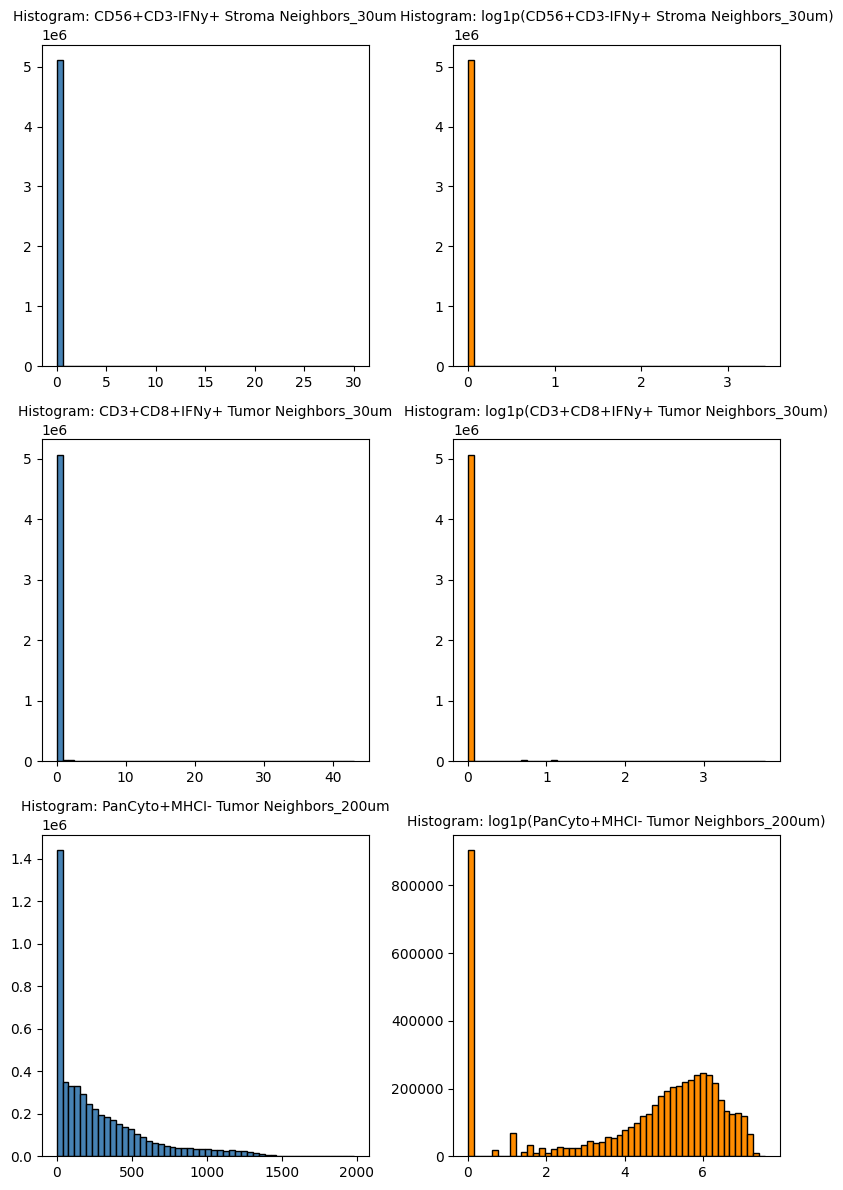

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define number of rows based on number of variables you're testing
num_rows = len(test_set)
num_cols = 2  # original and log1p

# Set figure size
square_size = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(square_size * num_cols, square_size * num_rows))

# Loop over variables
for i, col in enumerate(test_set_2):
    if col in full_df.columns:
        data = full_df[col].dropna()

        # Histogram for original values
        axes[i, 0].hist(data, bins=50, color='steelblue', edgecolor='black')
        axes[i, 0].set_title(f"Histogram: {col}", fontsize=10)

        # Histogram for log1p-transformed values
        log_data = np.log1p(data)
        axes[i, 1].hist(log_data, bins=50, color='darkorange', edgecolor='black')
        axes[i, 1].set_title(f"Histogram: log1p({col})", fontsize=10)
    else:
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


# Log 1p scaled

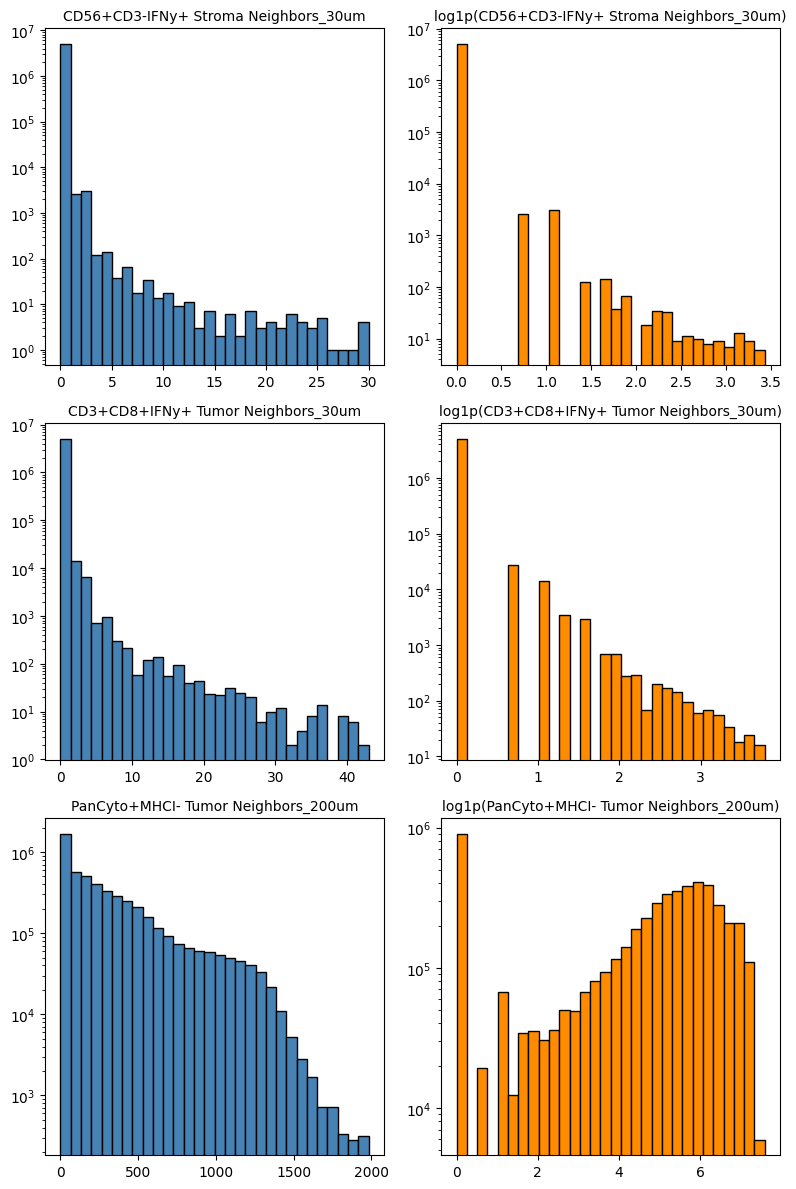

In [16]:
import matplotlib.pyplot as plt
import numpy as np

num_rows = len(test_set)
num_cols = 2
square_size = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(square_size * num_cols, square_size * num_rows))

for i, col in enumerate(test_set):
    if col in full_df.columns:
        data = full_df[col].dropna()

        # Original
        bars = axes[i, 0].hist(data, bins=30, color='steelblue', edgecolor='black')
        for patch in bars[2]:
            patch.set_rasterized(True)
        axes[i, 0].set_title(f"{col}", fontsize=10)
        axes[i, 0].set_yscale('log')

        # Log1p
        log_data = np.log1p(data)
        bars_log = axes[i, 1].hist(log_data, bins=30, color='darkorange', edgecolor='black')
        for patch in bars_log[2]:
            patch.set_rasterized(True)
        axes[i, 1].set_title(f"log1p({col})", fontsize=10)
        axes[i, 1].set_yscale('log')
    else:
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


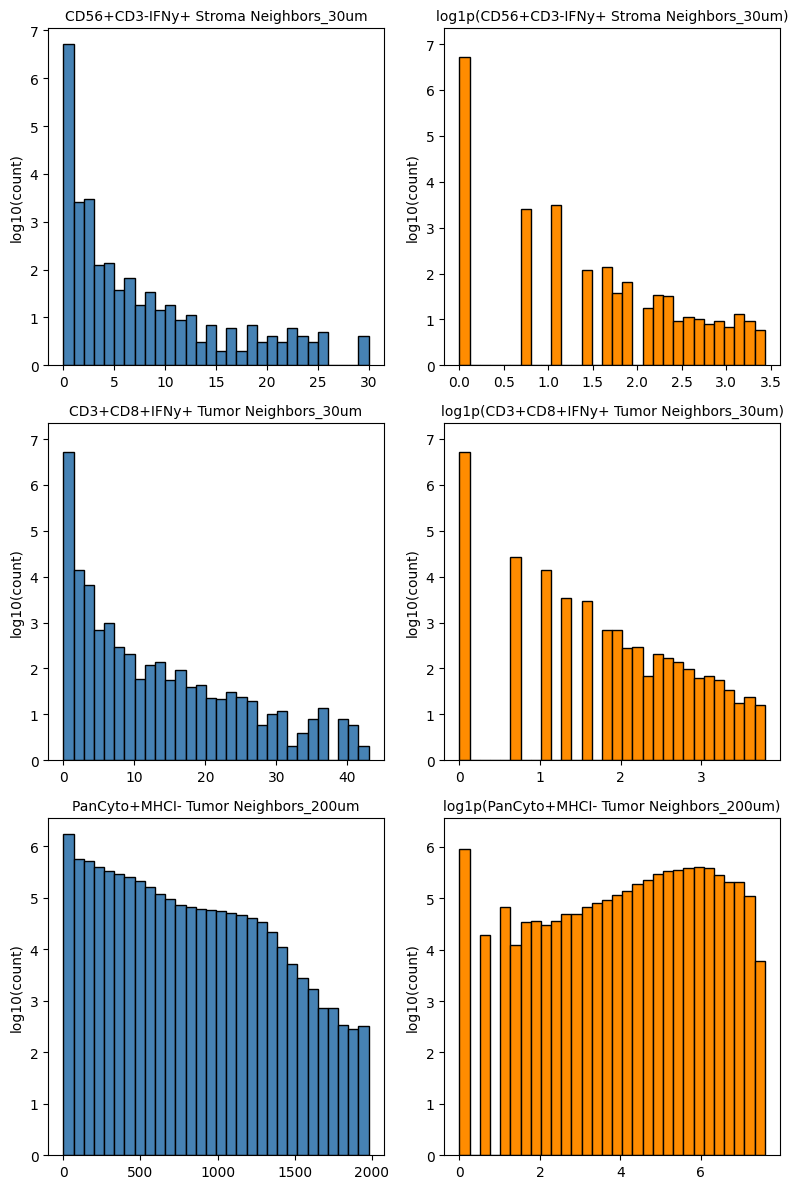

In [17]:
# log 10 for y scale
import matplotlib.pyplot as plt
import numpy as np

num_rows = len(test_set)
num_cols = 2
square_size = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(square_size * num_cols, square_size * num_rows))

for i, col in enumerate(test_set):
    if col in full_df.columns:
        data = full_df[col].dropna().values

        # Original histogram (manual log10 of counts)
        counts, bins = np.histogram(data, bins=30)
        bar_centers = (bins[:-1] + bins[1:]) / 2
        bar_widths = np.diff(bins)
        log_counts = np.log10(counts + 1e-6)

        axes[i, 0].bar(bar_centers, log_counts, width=bar_widths,
                       color=(70/255, 130/255, 180/255), edgecolor='black')
        axes[i, 0].set_title(f"{col}", fontsize=10)
        axes[i, 0].set_ylabel("log10(count)")
        axes[i, 0].set_ylim(bottom=0)

        # log1p-transformed histogram
        log_data = np.log1p(data)
        counts_log, bins_log = np.histogram(log_data, bins=30)
        bar_centers_log = (bins_log[:-1] + bins_log[1:]) / 2
        bar_widths_log = np.diff(bins_log)
        log_counts_log = np.log10(counts_log + 1e-6)

        axes[i, 1].bar(bar_centers_log, log_counts_log, width=bar_widths_log,
                       color=(255/255, 140/255, 0/255), edgecolor='black')
        axes[i, 1].set_title(f"log1p({col})", fontsize=10)
        axes[i, 1].set_ylabel("log10(count)")
        axes[i, 1].set_ylim(bottom=0)
    else:
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

plt.tight_layout()



plt.show()


# Here plot the cdf of the neighborhood distributions for the test features but only the non zero values

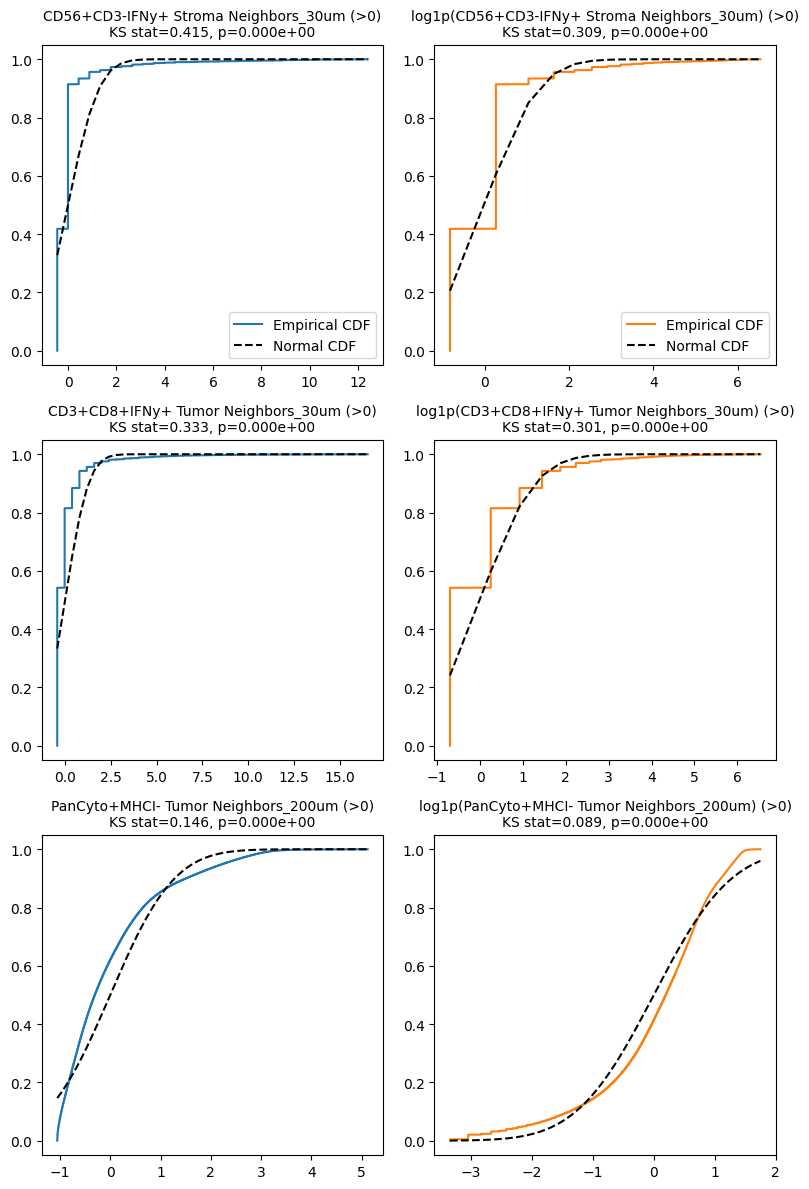

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd

ks_stats = []  # to store KS statistics

num_rows = len(test_set)
num_cols = 2  # original and log1p

square_size = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(square_size * num_cols, square_size * num_rows))

for i, col in enumerate(test_set):
    if col in full_df.columns:
        data = full_df[col].dropna()
        data = data[data > 0]  # filter to positive values only

        if len(data) < 10:
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
            continue

        # Normalize original and log1p data
        normed_data = (data - data.mean()) / data.std()
        log_data = np.log1p(data)
        normed_log_data = (log_data - log_data.mean()) / log_data.std()

        # KS tests
        stat_orig, pval_orig = stats.kstest(normed_data, 'norm')
        stat_log, pval_log = stats.kstest(normed_log_data, 'norm')

        # Save KS statistics
        ks_stats.append({'Feature': col, 'Original': stat_orig, 'Log1p': stat_log})

        # CDF plots: original
        ecdf_x = np.sort(normed_data)
        ecdf_y = np.arange(1, len(ecdf_x)+1) / len(ecdf_x)
        axes[i, 0].plot(ecdf_x, ecdf_y, label='Empirical CDF')
        axes[i, 0].plot(ecdf_x, stats.norm.cdf(ecdf_x), 'k--', label='Normal CDF')
        axes[i, 0].set_title(f"{col} (>0)\nKS stat={stat_orig:.3f}, p={pval_orig:.3e}", fontsize=10)

        # CDF plots: log1p
        ecdf_x_log = np.sort(normed_log_data)
        ecdf_y_log = np.arange(1, len(ecdf_x_log)+1) / len(ecdf_x_log)
        axes[i, 1].plot(ecdf_x_log, ecdf_y_log, label='Empirical CDF', color = 'tab:orange')
        axes[i, 1].plot(ecdf_x_log, stats.norm.cdf(ecdf_x_log), 'k--', label='Normal CDF')
        axes[i, 1].set_title(f"log1p({col}) (>0)\nKS stat={stat_log:.3f}, p={pval_log:.3e}", fontsize=10)

        if i == 0:
            axes[i, 0].legend()
            axes[i, 1].legend()
    else:
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

plt.tight_layout()


plt.show()



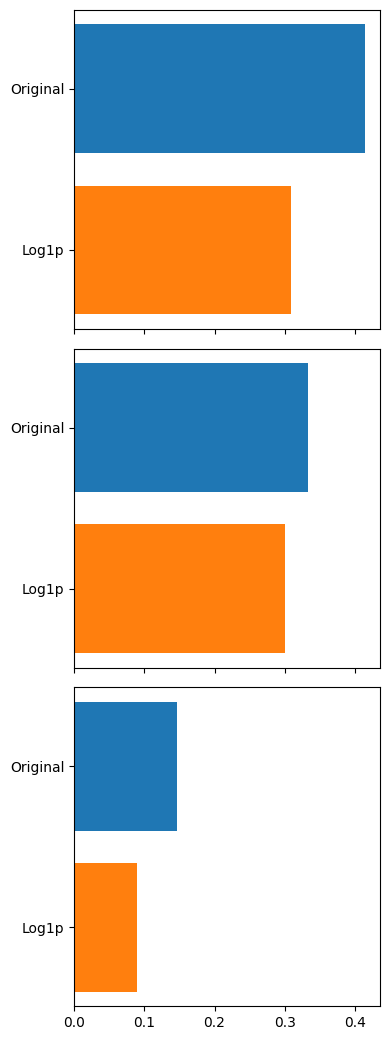

In [20]:
# plot the KS statistics as bar plots for fig F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert to DataFrame (no reversal)
ks_df = pd.DataFrame(ks_stats).reset_index(drop=True)

# Select top N features
n_bars = 3
ks_df_subset = ks_df.iloc[:n_bars]

# Plot
fig, axes = plt.subplots(nrows=n_bars, ncols=1, figsize=(4, 3.5 * n_bars), sharex=True)

for i, ax in enumerate(axes):
    row = ks_df_subset.iloc[i]
    values = [row['Original'], row['Log1p']]
    labels = ['Original', 'Log1p']
    
    # Bar plot with Original first, and inverted y-axis to place Original on top
    ax.barh(labels, values, color=['tab:blue', 'tab:orange'])
    ax.set_xlabel('')
    ax.set_title('')
    ax.invert_yaxis()  # <-- This ensures "Original" appears visually on top

plt.tight_layout()
plt.show()


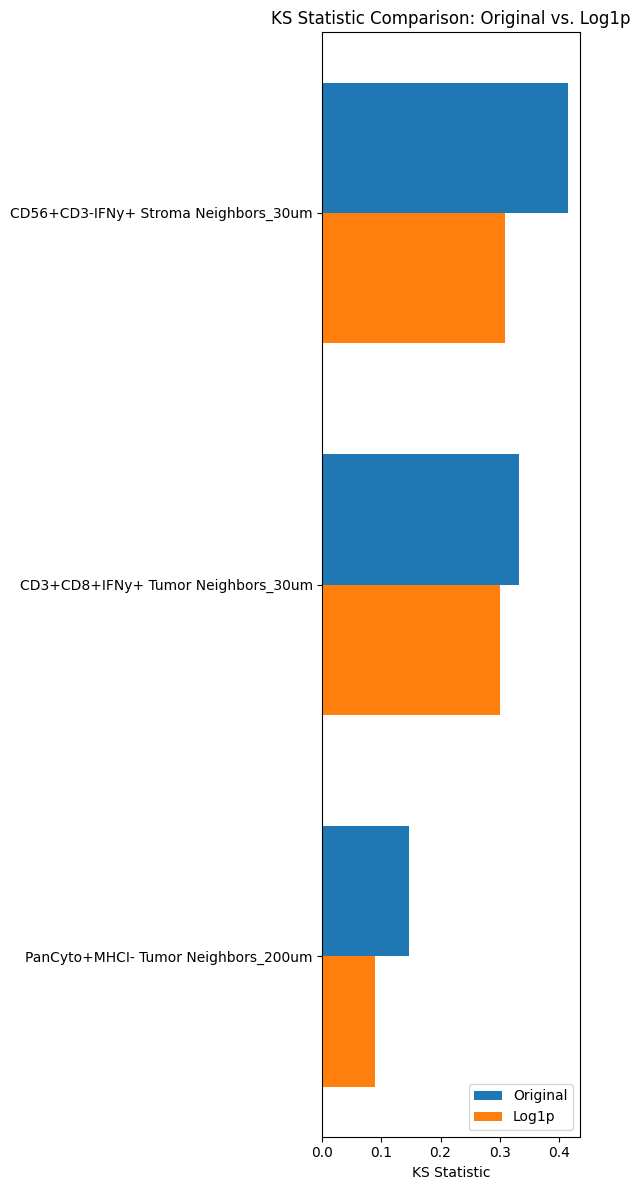

In [21]:
# adjust the plot aesthetics 
# Convert KS stats to DataFrame
ks_df = pd.DataFrame(ks_stats)
ks_df = ks_df[::-1]

# Plot bar chart
x = np.arange(len(ks_df['Feature']))
width = 0.35

fig, ax = plt.subplots(figsize=(6,12))
ax.barh(x + width/2, ks_df['Original'], width, label='Original')
ax.barh(x - width/2, ks_df['Log1p'], width, label='Log1p')

ax.set_xlabel('KS Statistic')
ax.set_title('KS Statistic Comparison: Original vs. Log1p')
ax.set_yticks(x)
ax.set_yticklabels(ks_df['Feature'])
ax.legend()

plt.tight_layout()


plt.show()